## Natural Language Processing with Disaster Tweets

### Problem Description

In this project, I aim to classify tweets based on whether they refer to a real disaster or not. Twitter has become a key platform for real-time communication, especially during emergencies, and identifying relevant tweets can help disaster relief organizations and news agencies respond more effectively.

The challenge lies in training a machine learning model to differentiate between tweets that are genuinely about a disaster and those that are not. Some tweets might use disaster-related words metaphorically, making it difficult for a machine to distinguish the context without proper understanding of the tweet's intent.

I will use Natural Language Processing (NLP) techniques to process the tweets and classify them accordingly.

### Dataset Overview

I have access to the following datasets:
- **train.csv**: Contains ~10,000 tweets with five columns: `id`, `keyword`, `location`, `text`, and `target`.
  - The `text` column contains the actual tweet content.
  - The `keyword` and `location` columns might be useful features, but they contain missing values.
  - The `target` column indicates whether the tweet is about a real disaster (1) or not (0).
  
- **test.csv**: Contains ~3,200 tweets with four columns: `id`, `keyword`, `location`, and `text`, but without the `target` label.
  
- **sample_submission.csv**: A file that shows the expected format for the submission, with columns `id` and `target`.

### Objective

The goal of this project is to build a machine learning model that can classify whether a tweet refers to a real disaster or not, based on its content. I will preprocess the text, build and train a neural network model, and evaluate its performance on the test data.


In [1]:
# CODE BLOCK 1:
import warnings
import os

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP specific libraries
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# For neural networks
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Other utilities
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Download NLTK stopwords
nltk.download('stopwords')

# Set up visualization styling
sns.set(style="whitegrid")

# GPU and mixed precision setup
tf.config.optimizer.set_jit(True)  # Enable XLA (Accelerated Linear Algebra optimization)

# Configurations
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
warnings.simplefilter('ignore', UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Configure GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Error while setting memory growth:", e)

# Set global mixed precision policy
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision policy set to:", mixed_precision.global_policy().name)

# Check available devices
print("Available devices:", tf.config.list_logical_devices())

# Check if TensorFlow is built with CUDA
print("Is TensorFlow built with CUDA:", tf.test.is_built_with_cuda())

# Check number of available GPUs
print("Num GPUs Available:", len(gpus))

2024-10-23 10:11:37.202050: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-23 10:11:38.208500: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package stopwords to /home/panog/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Mixed precision policy set to: mixed_float16
Available devices: [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
Is TensorFlow built with CUDA: True
Num GPUs Available: 1


2024-10-23 10:11:39.417379: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-23 10:11:39.449764: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-23 10:11:39.449826: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-23 10:11:39.453725: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-23 10:11:39.453791: I external/local_xla/xla/stream_executor

In [2]:
# CODE BLOCK 2:
# Load the datasets
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

# Show the first few rows of the training data to understand its structure
print("Training Data Overview:")
display(train_data.head())

# Show basic information about the training data (size, column names, and data types)
print("\nTraining Data Info:")
train_data.info()

# Checking the structure of the test data
print("\nTest Data Overview:")
display(test_data.head())

print("\nTest Data Info:")
test_data.info()

# Describe the target distribution in the training data
print("\nTarget Distribution in Training Data:")
print(train_data['target'].value_counts(normalize=True))

# Check for missing values in train and test data
print("\nMissing Values in Training Data:")
print(train_data.isnull().sum())

print("\nMissing Values in Test Data:")
print(test_data.isnull().sum())


Training Data Overview:


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1



Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB

Test Data Overview:


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan



Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB

Target Distribution in Training Data:
target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

Missing Values in Training Data:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing Values in Test Data:
id             0
keyword       26
location    1105
text           0
dtype: int64


In [3]:
# CODE BLOCK 3: Enhanced Data Cleaning with Conditional Keyword Inclusion

import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import html

# Ensure necessary NLTK data is downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# 1. Replace '%20' with spaces in the 'keyword' column
train_data['keyword'] = train_data['keyword'].str.replace('%20', ' ')
test_data['keyword'] = test_data['keyword'].str.replace('%20', ' ')

# 2. Fill missing keywords with 'none'
train_data['keyword'] = train_data['keyword'].fillna('none')
test_data['keyword'] = test_data['keyword'].fillna('none')

# 3. Drop the 'location' column
train_data = train_data.drop(columns=['location'])
test_data = test_data.drop(columns=['location'])

# 4. Define patterns and initialize tools
URL_PATTERN = re.compile(r'https?://\S+|www\.\S+')
EMOJI_PATTERN = re.compile(
    "["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags
    "]+",
    flags=re.UNICODE,
)

# Contraction mapping
CONTRACTION_MAP = {
    "can't": "cannot",
    "won't": "will not",
    "n't": " not",
    "'re": " are",
    "'s": " is",
    "'d": " would",
    "'ll": " will",
    "'ve": " have",
    "'m": " am",
    # Add more contractions as needed
}

lemmatizer = WordNetLemmatizer()

# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ  # Adjective
    elif tag.startswith('V'):
        return wordnet.VERB  # Verb
    elif tag.startswith('N'):
        return wordnet.NOUN  # Noun
    elif tag.startswith('R'):
        return wordnet.ADV  # Adverb
    else:
        return wordnet.NOUN  # Default to noun

def clean_text(text):
    # Ensure input is a string
    text = str(text)
    # Decode HTML entities
    text = html.unescape(text)
    # Convert to lowercase
    text = text.lower()
    # Handle contractions
    for contraction, expansion in CONTRACTION_MAP.items():
        text = text.replace(contraction, expansion)
    # Replace 'u' with 'you'
    text = re.sub(r'\bu\b', 'you', text)
    # Remove URLs
    text = re.sub(URL_PATTERN, '', text)
    # Remove emojis
    text = re.sub(EMOJI_PATTERN, '', text)
    # Remove 'amp' (from '&amp;')
    text = text.replace('amp', '')
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # POS tagging
    pos_tags = pos_tag(tokens)
    # Lemmatize tokens with POS tags
    tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in pos_tags]
    # Join tokens back to string
    text = ' '.join(tokens)
    return text.strip()

# 5. Combine 'keyword' and 'text' columns conditionally
def combine_keyword_text(row):
    if row['keyword'].lower() != 'none':
        return row['keyword'] + ' ' + row['text']
    else:
        return row['text']

train_data['combined_text'] = train_data.apply(combine_keyword_text, axis=1)
test_data['combined_text'] = test_data.apply(combine_keyword_text, axis=1)

# 6. Apply text cleaning to the combined text
train_data['combined_text'] = train_data['combined_text'].apply(clean_text)
test_data['combined_text'] = test_data['combined_text'].apply(clean_text)

# 7. Check the cleaned training data
print("Cleaned Training Data Overview:")
display(train_data[['id', 'keyword', 'text', 'combined_text', 'target']].head())

# 8. Removing stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply the function to remove stopwords on the combined text
train_data['combined_text'] = train_data['combined_text'].apply(remove_stopwords)
test_data['combined_text'] = test_data['combined_text'].apply(remove_stopwords)

# Check the cleaned training data again after stopword removal
print("Training Data After Stopword Removal:")
display(train_data[['id', 'combined_text', 'target']].head())

[nltk_data] Downloading package stopwords to /home/panog/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/panog/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/panog/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/panog/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Cleaned Training Data Overview:


,id,keyword,text,combined_text,target
0,1,none,Our Deeds are the Reason of this #earthquake M...,our deed be the reason of this earthquake may ...,1
1,4,none,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,1
2,5,none,All residents asked to 'shelter in place' are ...,all resident ask to ishelter in place be be no...,1
3,6,none,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfire evacuation order...,1
4,7,none,Just got sent this photo from Ruby #Alaska as ...,just get send this photo from ruby alaska a sm...,1


Training Data After Stopword Removal:


,id,combined_text,target
0,1,deed reason earthquake may allah forgive u,1
1,4,forest fire near la ronge sask canada,1
2,5,resident ask ishelter place notify officer eva...,1
3,6,13000 people receive wildfire evacuation order...,1
4,7,get send photo ruby alaska smoke wildfire pour...,1


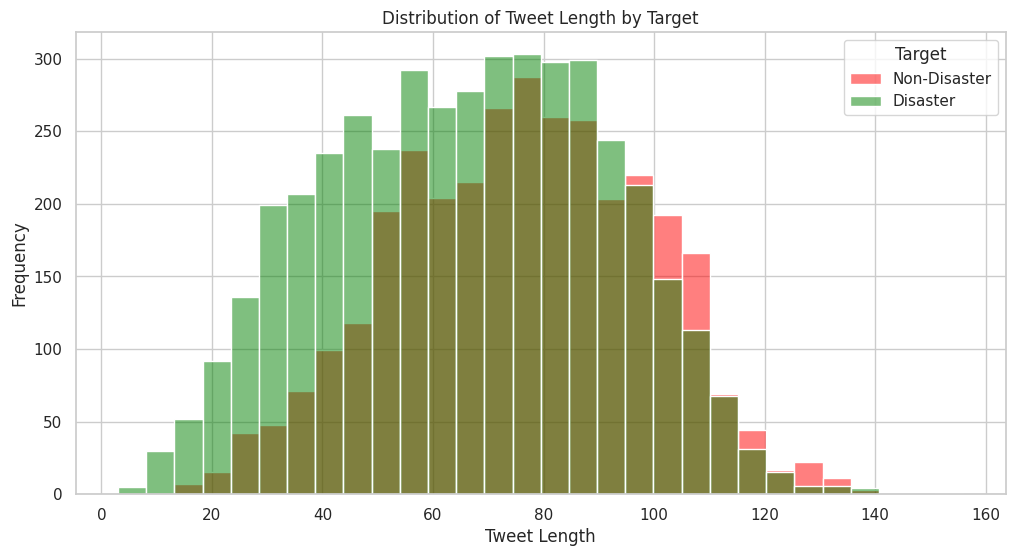

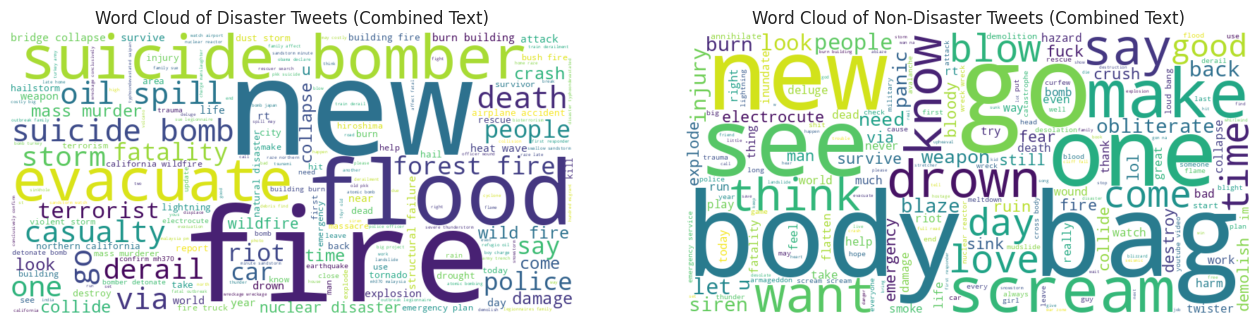

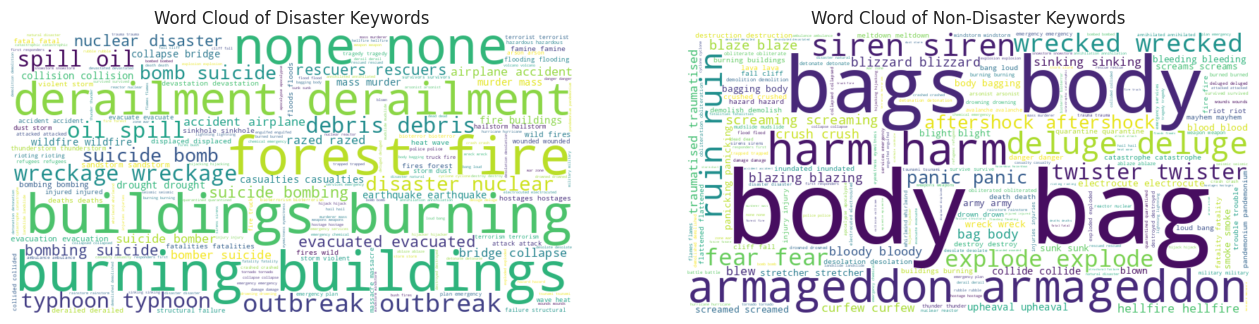

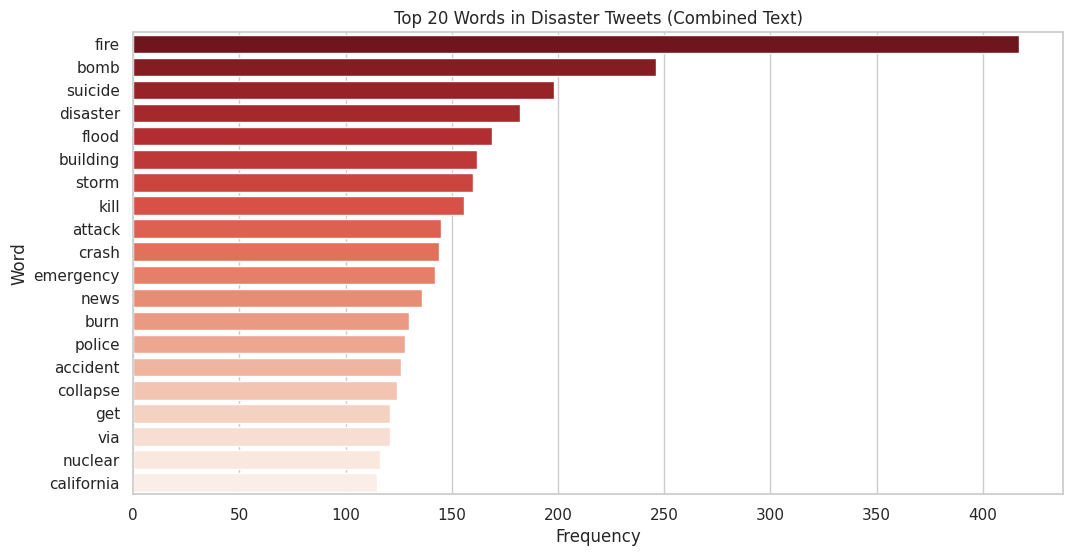

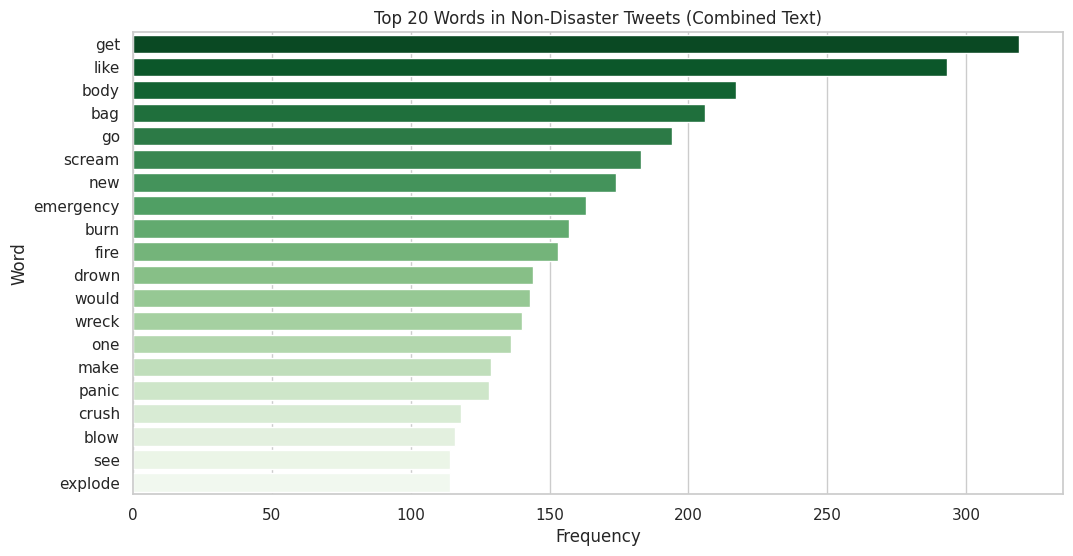

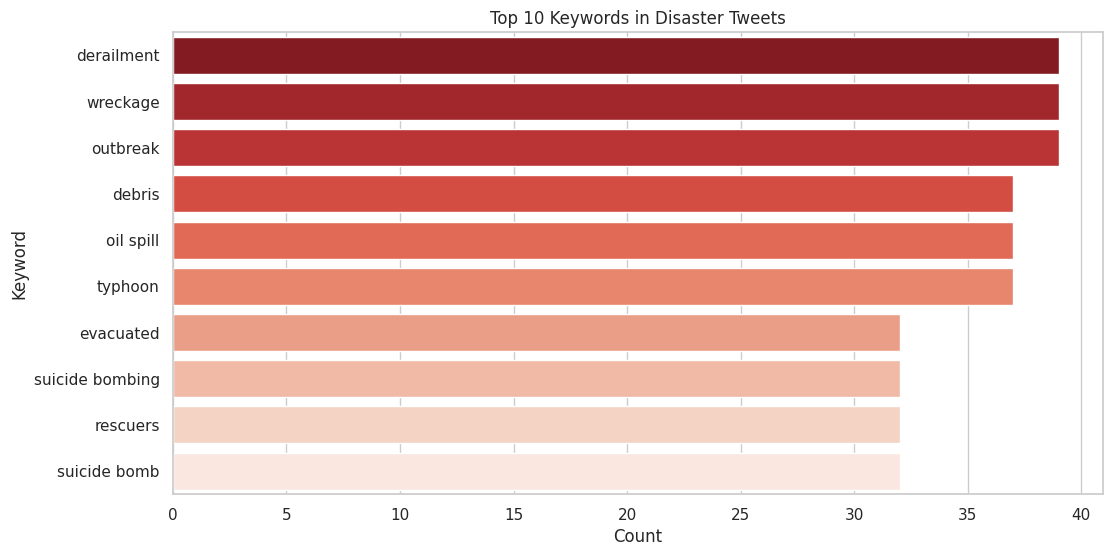

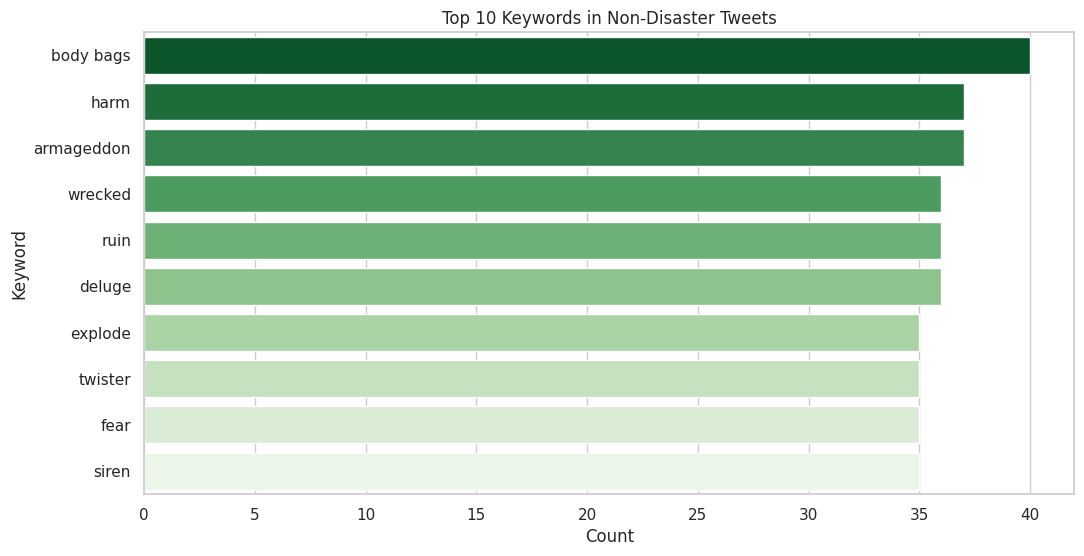

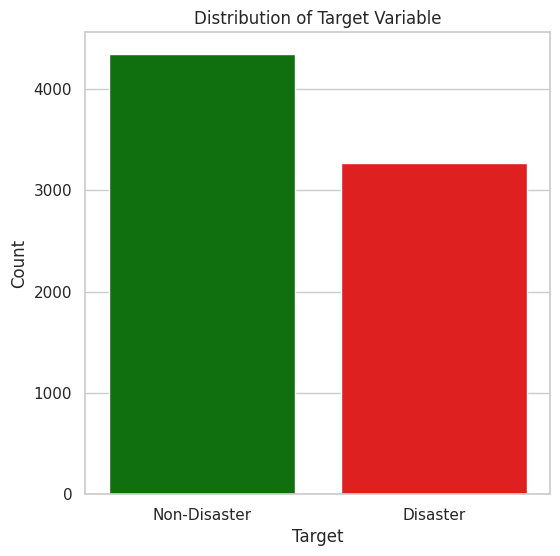

Average tweet length for disaster tweets: 75.77 characters
Average tweet length for non-disaster tweets: 66.06 characters


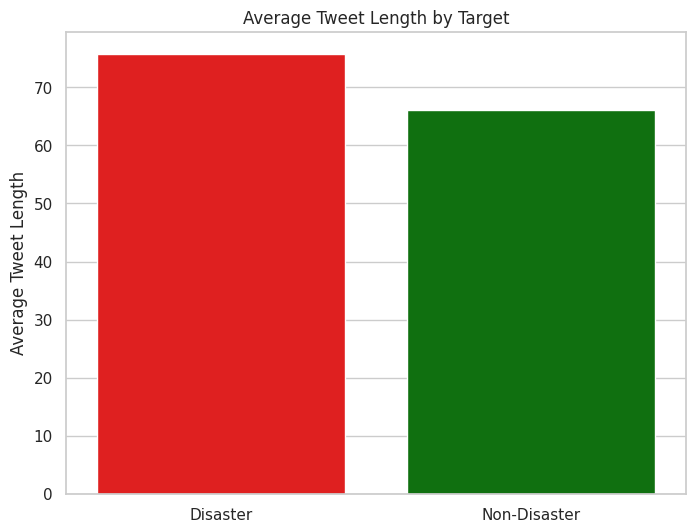

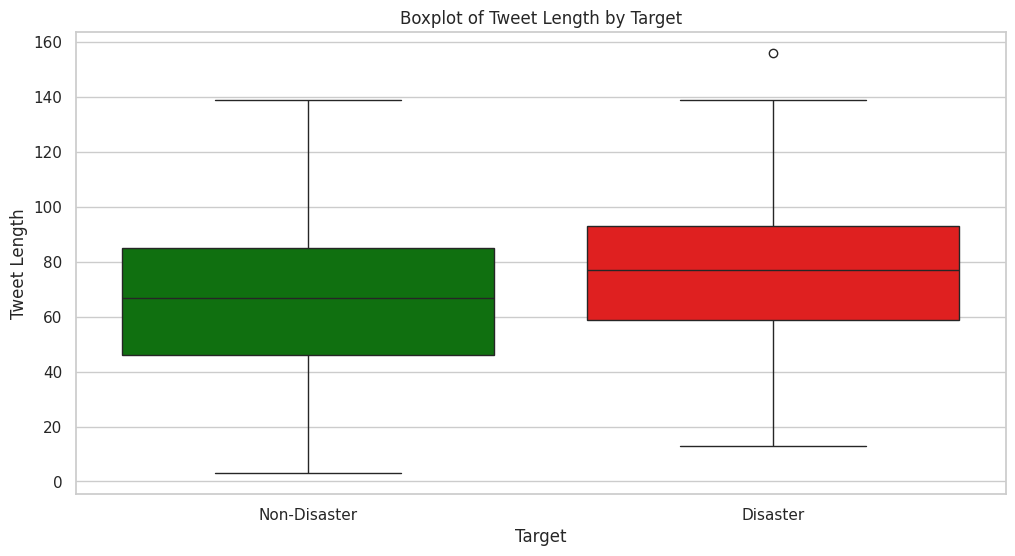

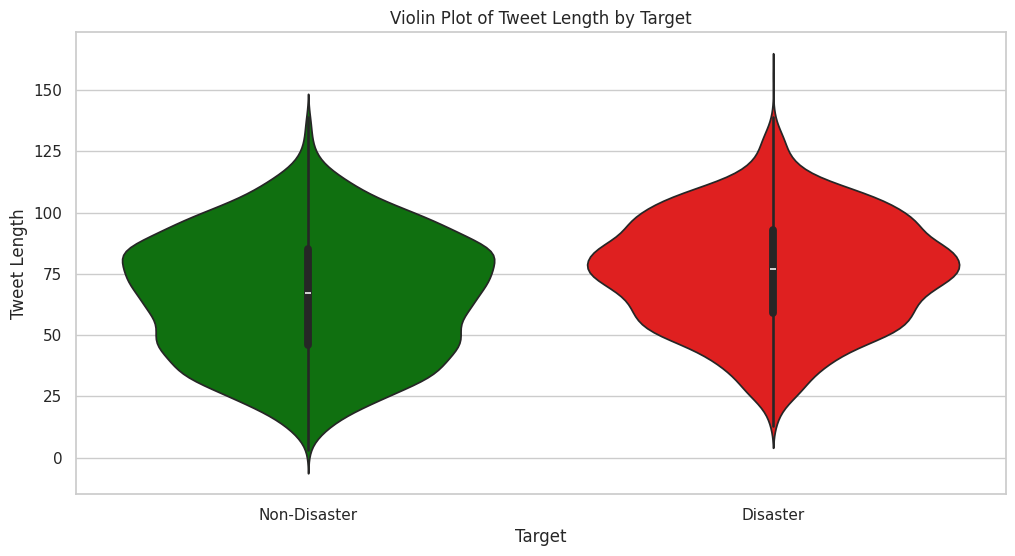

In [4]:
# CODE BLOCK 4: Enhanced Data Visualization with Updated Preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# 1. Tweet Length Distribution by Target

# Add a column for tweet length (number of characters) from 'combined_text'
train_data['tweet_length'] = train_data['combined_text'].apply(len)

# Plotting tweet length distribution for disaster and non-disaster tweets
plt.figure(figsize=(12, 6))
sns.histplot(data=train_data, x='tweet_length', hue='target', bins=30, kde=False, palette=['green', 'red'])
plt.title('Distribution of Tweet Length by Target')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.legend(title='Target', labels=['Non-Disaster', 'Disaster'])
plt.show()

# 2. Word Clouds for Disaster and Non-Disaster Combined Text

# Generate word cloud for disaster tweets
disaster_text = ' '.join(train_data[train_data['target'] == 1]['combined_text'])
disaster_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(disaster_text)

# Generate word cloud for non-disaster tweets
nondisaster_text = ' '.join(train_data[train_data['target'] == 0]['combined_text'])
nondisaster_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(nondisaster_text)

# Plot word clouds side by side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(disaster_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Disaster Tweets (Combined Text)')

plt.subplot(1, 2, 2)
plt.imshow(nondisaster_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Non-Disaster Tweets (Combined Text)')

plt.show()

# 3. Word Clouds for Disaster and Non-Disaster Keywords

# Generate word cloud for disaster keywords
disaster_keywords_text = ' '.join(train_data[train_data['target'] == 1]['keyword'])
disaster_keywords_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(disaster_keywords_text)

# Generate word cloud for non-disaster keywords
nondisaster_keywords_text = ' '.join(train_data[train_data['target'] == 0]['keyword'])
nondisaster_keywords_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(nondisaster_keywords_text)

# Plot keyword word clouds side by side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(disaster_keywords_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Disaster Keywords')

plt.subplot(1, 2, 2)
plt.imshow(nondisaster_keywords_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Non-Disaster Keywords')

plt.show()

# 4. Bar Plots of Most Common Words in Disaster and Non-Disaster Combined Text

# Function to get most common words
def get_top_n_words(corpus, n=None):
    tokens = ' '.join(corpus).split()
    counter = Counter(tokens)
    return counter.most_common(n)

# Get top 20 words for disaster tweets
top_words_disaster = get_top_n_words(train_data[train_data['target'] == 1]['combined_text'], n=20)
top_df_disaster = pd.DataFrame(top_words_disaster, columns=['Word', 'Frequency'])

# Get top 20 words for non-disaster tweets
top_words_nondisaster = get_top_n_words(train_data[train_data['target'] == 0]['combined_text'], n=20)
top_df_nondisaster = pd.DataFrame(top_words_nondisaster, columns=['Word', 'Frequency'])

# Plot top words for disaster tweets
plt.figure(figsize=(12, 6))
sns.barplot(data=top_df_disaster, x='Frequency', y='Word', palette='Reds_r')
plt.title('Top 20 Words in Disaster Tweets (Combined Text)')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

# Plot top words for non-disaster tweets
plt.figure(figsize=(12, 6))
sns.barplot(data=top_df_nondisaster, x='Frequency', y='Word', palette='Greens_r')
plt.title('Top 20 Words in Non-Disaster Tweets (Combined Text)')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

# 5. Bar Plots of the Most Common Keywords in Both Classes

# Top 10 keywords in disaster tweets
disaster_keywords = train_data[train_data['target'] == 1]['keyword']
disaster_keywords = disaster_keywords[disaster_keywords != 'none']  # Exclude 'none'
disaster_keyword_counts = disaster_keywords.value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=disaster_keyword_counts.values, y=disaster_keyword_counts.index, palette='Reds_r')
plt.title('Top 10 Keywords in Disaster Tweets')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.show()

# Top 10 keywords in non-disaster tweets
nondisaster_keywords = train_data[train_data['target'] == 0]['keyword']
nondisaster_keywords = nondisaster_keywords[nondisaster_keywords != 'none']  # Exclude 'none'
nondisaster_keyword_counts = nondisaster_keywords.value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=nondisaster_keyword_counts.values, y=nondisaster_keyword_counts.index, palette='Greens_r')
plt.title('Top 10 Keywords in Non-Disaster Tweets')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.show()

# 6. Distribution of Target Variable

# Plotting the distribution of the target variable
plt.figure(figsize=(6, 6))
sns.countplot(x='target', data=train_data, palette=['green', 'red'])
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Disaster', 'Disaster'])
plt.show()

# 7. Average Tweet Length by Target

# Calculate average tweet length for each class
avg_length_disaster = train_data[train_data['target'] == 1]['tweet_length'].mean()
avg_length_nondisaster = train_data[train_data['target'] == 0]['tweet_length'].mean()

print(f"Average tweet length for disaster tweets: {avg_length_disaster:.2f} characters")
print(f"Average tweet length for non-disaster tweets: {avg_length_nondisaster:.2f} characters")

# Plotting average tweet length
plt.figure(figsize=(8, 6))
sns.barplot(x=['Disaster', 'Non-Disaster'], y=[avg_length_disaster, avg_length_nondisaster], palette=['red', 'green'])
plt.title('Average Tweet Length by Target')
plt.ylabel('Average Tweet Length')
plt.show()

# 8. Boxplot of Tweet Lengths by Target

plt.figure(figsize=(12, 6))
sns.boxplot(x='target', y='tweet_length', data=train_data, palette=['green', 'red'])
plt.title('Boxplot of Tweet Length by Target')
plt.xlabel('Target')
plt.ylabel('Tweet Length')
plt.xticks([0, 1], ['Non-Disaster', 'Disaster'])
plt.show()

# 9. Violin Plot of Tweet Lengths by Target

plt.figure(figsize=(12, 6))
sns.violinplot(x='target', y='tweet_length', data=train_data, palette=['green', 'red'])
plt.title('Violin Plot of Tweet Length by Target')
plt.xlabel('Target')
plt.ylabel('Tweet Length')
plt.xticks([0, 1], ['Non-Disaster', 'Disaster'])
plt.show()

### Plan of Analysis

Based on the exploratory data analysis (EDA), we will follow the steps below to build a predictive model for classifying disaster-related tweets:

1. **Text Vectorization**:
   We will use **pre-trained GloVe (Global Vectors for Word Representation)** embeddings for text vectorization. These embeddings map each word to a dense vector space based on its semantic relationships with other words. This allows the model to better understand the context and relationships between words in disaster-related tweets. The GloVe embeddings will be used as initial weights in an embedding layer, and the tweets will be tokenized and padded to ensure uniform input length.

2. **Feature Engineering**:
   We have extracted additional features from the text data that could provide more predictive power:
   - **Hashtag counts**: We observed in the distribution plots that disaster-related tweets tend to contain more hashtags than non-disaster ones. This feature may help differentiate between the two classes.
   - **Mentions counts**: Tweets mentioning others using '@' were also tracked. The presence of mentions could be more prevalent in non-disaster tweets.
   - **URLs in tweets**: Disaster-related tweets were found to contain more URLs, which we visualized in the bar plot. This feature could further aid in distinguishing between disaster and non-disaster tweets.

3. **Text Preprocessing**:
   During the preprocessing steps, we cleaned the text data by:
   - **Removing emojis, URLs, and special characters**.
   - **Replacing hashtags and mentions** with spaces to avoid their influence on tokenization.
   - **Lemmatizing keywords** to unify words with the same meaning (e.g., "evacuate" and "evacuated"). 

   We also handled common and irrelevant words like 'new,' 'people,' and 'amp' that appeared in both disaster and non-disaster tweets. These words were removed to focus on more meaningful words that contribute to tweet classification.

4. **Class Imbalance**:
   The target distribution shows that around 57% of the tweets are non-disaster-related, while 43% are disaster-related. Although the imbalance is not extreme, we will account for it by assigning class weights during model training to ensure the model does not become biased toward the majority class.

5. **Model Architecture**:
   We will build a **sequential neural network** using the following architecture:
   - **Embedding Layer**: Pre-trained GloVe embeddings will be used to represent the tweets in dense vectors.
   - **LSTM Layers**: A combination of **Bidirectional LSTMs** and regular LSTM layers will be used to capture the order and context of the words in each tweet. This will help the model understand dependencies within the text sequence.
   - **Dense Layer**: A fully connected layer will combine the features learned by the LSTM layers, helping the model make the final classification.
   - **Dropout and Regularization**: We will use **L2 regularization** and **Dropout** to reduce overfitting.
   - **Output Layer**: A sigmoid activation function will be used for binary classification (disaster vs. non-disaster).

6. **Model Evaluation**:
   We will evaluate the model’s performance using metrics such as accuracy, precision, recall, and the F1-score. Given the critical nature of detecting disaster-related tweets, a high recall will be essential to minimize false negatives, ensuring that disaster tweets are not misclassified as non-disaster. The confusion matrix will provide further insights into the types of errors the model makes (false positives vs. false negatives).

7. **Hyperparameter Tuning**:
   We will optimize the model by tuning hyperparameters such as the number of LSTM units, dropout rate, learning rate, and whether to train the embedding layer using **Keras Tuner**. This tuning process will ensure that the model performs optimally and generalizes well to unseen data.

By following this analysis plan, we aim to build a robust model capable of accurately distinguishing disaster-related tweets from non-disaster-related ones based on the observed trends in the data.

In [5]:
# CODE BLOCK 5:
 # Step 1: Load GloVe embeddings (make sure you download 'glove.6B.100d.txt')
embedding_dim = 300  # 100-dimensional GloVe embeddings
glove_path = 'glove.6B.300d.txt'

# Create a dictionary mapping words to their GloVe embeddings
embeddings_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Step 2: Tokenize the text data
max_words = 14000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data['text'])

X_train_seq = tokenizer.texts_to_sequences(train_data['text'])
X_test_seq = tokenizer.texts_to_sequences(test_data['text'])

# Pad sequences to ensure uniform input length
maxlen = 100  # Limiting tweet length to 100 words
X_train_padded = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_padded = pad_sequences(X_test_seq, maxlen=maxlen)

# Step 3: Create the embedding matrix
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Display the shape of the padded data
print(f"Train Data Shape: {X_train_padded.shape}")
print(f"Test Data Shape: {X_test_padded.shape}")

# Target values (for training data only)
y_train = train_data['target'].values

Train Data Shape: (7613, 100)
Test Data Shape: (3263, 100)


In [6]:
# CODE BLOCK 6:
# Define the input shape
input_shape = (maxlen,)

# Define the LSTM model with GloVe embeddings
model = Sequential()

# Add the Input layer to explicitly define the input shape
model.add(Input(shape=input_shape))

# Embedding layer initialized with GloVe embeddings, explicitly setting input_length
model.add(Embedding(input_dim=max_words,
                    output_dim=embedding_dim,
                    input_length=maxlen,
                    weights=[embedding_matrix],
                    trainable=False))

# LSTM layer with 128 units
model.add(LSTM(128, return_sequences=False))

# Dense layer with 128 units and Dropout layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

# Output layer: Sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with a lower learning rate for more fine-tuned learning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 300)       │     4,200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,436,289 (16.92 MB)

 Trainable params: 236,289 (923.00 KB)

 Non-trainable params: 4,200,000 (16.02 MB)

Epoch 1/20


I0000 00:00:1729692733.885176 2764065 service.cc:145] XLA service 0x7f8fec0039a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729692733.885237 2764065 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-10-23 10:12:13.910452: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8904
I0000 00:00:1729692734.004428 2764065 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-10-23 10:12:14.188682: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.6214 - loss: 0.6576 - val_accuracy: 0.7551 - val_loss: 0.5558
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.7745 - loss: 0.5158 - val_accuracy: 0.7886 - val_loss: 0.4628
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7942 - loss: 0.4500 - val_accuracy: 0.8004 - val_loss: 0.4476
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8117 - loss: 0.4289 - val_accuracy: 0.8109 - val_loss: 0.4243
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8200 - loss: 0.4242 - val_accuracy: 0.8135 - val_loss: 0.4182
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8312 - loss: 0.4024 - val_accuracy: 0.8096 - val_loss: 0.4196
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8166 - loss: 0.4127 - val_accuracy: 0.8096 - val_loss: 0.4184
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8377 - loss: 0.3970 - val_accuracy: 0.8181 - val_loss: 0.

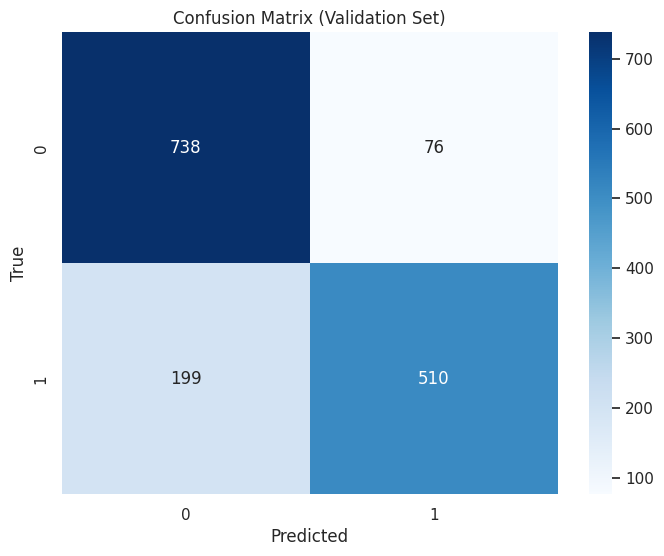

Classification Report (Validation Set):
              precision    recall  f1-score   support

Non-Disaster       0.79      0.91      0.84       814
    Disaster       0.87      0.72      0.79       709

    accuracy                           0.82      1523
   macro avg       0.83      0.81      0.82      1523
weighted avg       0.83      0.82      0.82      1523



In [7]:
# CODE BLOCK 7:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Train the model with more epochs and a validation split
history = model.fit(X_train_padded, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=1)

# Get the validation data from the training history
val_loss, val_accuracy = model.evaluate(X_train_padded[int(len(X_train_padded) * 0.8):],
                                        y_train[int(len(y_train) * 0.8):], verbose=1)

# Predict on the validation set
y_val_pred = model.predict(X_train_padded[int(len(X_train_padded) * 0.8):])
y_val_pred = (y_val_pred > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

# True validation labels
y_val_true = y_train[int(len(y_train) * 0.8):]

# Confusion Matrix
cm = confusion_matrix(y_val_true, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Validation Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
report = classification_report(y_val_true, y_val_pred, target_names=['Non-Disaster', 'Disaster'])
print("Classification Report (Validation Set):")
print(report)

## Base Model Summary

For the base model, I built a sequential LSTM model using GloVe embeddings for disaster tweet classification. The architecture is simple, with an embedding layer initialized with GloVe embeddings, followed by an LSTM layer, a dense layer, a dropout layer to prevent overfitting, and a final dense output layer for binary classification. The model was trained over 20 epochs.

### Model Architecture

| Layer (Type)   | Output Shape   | Parameters  |
|----------------|----------------|-------------|
| **Embedding**  | (None, 100, 100) | 1,000,000   |
| **LSTM**       | (None, 128)     | 117,248     |
| **Dense**      | (None, 128)     | 16,512      |
| **Dropout**    | (None, 128)     | 0           |
| **Dense_1**    | (None, 1)       | 129         |
| **Total**      | **Params:** 1,133,889 | **Trainable Params:** 133,889 |
|                |                | **Non-Trainable Params:** 1,000,000 |


## Training Overview

The model was trained on the preprocessed and tokenized dataset using GloVe embeddings. The input data consists of 7,613 training examples and 3,263 test examples, both padded to a maximum length of 100 tokens. Below are the results over 20 epochs:

| **Epoch** | **Accuracy** | **Loss** | **Val Accuracy** | **Val Loss** |
|-----------|--------------|----------|------------------|--------------|
| 1         | 0.8348       | 0.3847   | 0.8116           | 0.4270       |
| 2         | 0.8308       | 0.3926   | 0.8102           | 0.4336       |
| 3         | 0.8367       | 0.3768   | 0.8116           | 0.4345       |
| 4         | 0.8422       | 0.3790   | 0.8089           | 0.4386       |
| 5         | 0.8386       | 0.3838   | 0.8109           | 0.4326       |
| 6         | 0.8414       | 0.3750   | 0.8102           | 0.4367       |
| 7         | 0.8422       | 0.3653   | 0.8083           | 0.4358       |
| 8         | 0.8449       | 0.3592   | 0.8070           | 0.4326       |
| 9         | 0.8447       | 0.3584   | 0.8129           | 0.4400       |
| 10        | 0.8409       | 0.3653   | 0.8070           | 0.4543       |
| 11        | 0.8495       | 0.3459   | 0.8076           | 0.4475       |
| 12        | 0.8565       | 0.3425   | 0.8063           | 0.4521       |
| 13        | 0.8547       | 0.3465   | 0.8083           | 0.4649       |
| 14        | 0.8655       | 0.3300   | 0.8063           | 0.4564       |
| 15        | 0.8656       | 0.3256   | 0.8109           | 0.4555       |
| 16        | 0.8755       | 0.3142   | 0.8096           | 0.4631       |
| 17        | 0.8649       | 0.3208   | 0.8122           | 0.4757       |
| 18        | 0.8838       | 0.2975   | 0.8030           | 0.4832       |
| 19        | 0.8695       | 0.3127   | 0.8102           | 0.4848       |
| 20        | 0.8700       | 0.3189   | 0.8109           | 0.4797       |

## Evaluation Results

### Confusion Matrix

The model was evaluated on the validation set, resulting in the confusion matrix below:

![Confusion Matrix](images/base_model_confusion_matrix.png)

### Classification Report

| **Class**      | **Precision** | **Recall** | **F1-Score** | **Support** |
|----------------|---------------|------------|--------------|-------------|
| **Non-Disaster** | 0.79          | 0.87       | 0.83         | 814         |
| **Disaster**   | 0.83          | 0.74       | 0.79         | 709         |
| **Accuracy**   |               |            | 0.81         | 1,523       |
| **Macro Avg**  | 0.81          | 0.81       | 0.81         | 1,523       |
| **Weighted Avg** | 0.81        | 0.81       | 0.81         | 1,523       |


### Summary

- The base model achieved an accuracy of **81%** on the validation set.
- The model shows better precision for disaster tweets (83%) than non-disaster tweets (79%), though recall for disaster tweets could be improved (currently 74%).
- The model may be overfitting slightly towards the end of training, as validation loss increases, while accuracy remains relatively stable. Regularization techniques like dropout helped mitigate overfitting to some extent.

Trial 90 Complete [00h 02m 52s]
val_accuracy: 0.8115561604499817

Best val_accuracy So Far: 0.8240315318107605
Total elapsed time: 01h 08m 04s
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8389 - loss: 0.5778
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


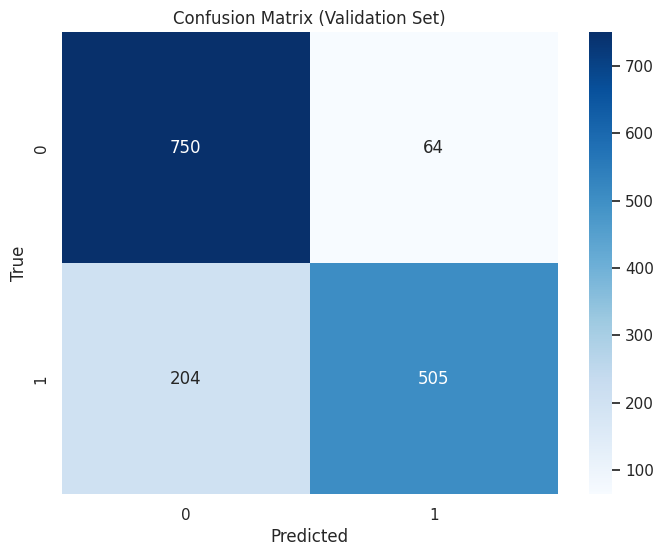

Classification Report (Validation Set):
              precision    recall  f1-score   support

Non-Disaster       0.79      0.92      0.85       814
    Disaster       0.89      0.71      0.79       709

    accuracy                           0.82      1523
   macro avg       0.84      0.82      0.82      1523
weighted avg       0.83      0.82      0.82      1523


Best Hyperparameters found:
LSTM Units 1: 64
LSTM Units 2: 128
Dense Units: 128
Dropout Rate: 0.30000000000000004
Learning Rate: 0.0012343057544000793
Trainable Embedding: True


In [8]:
# CODE BLOCK 9

from keras_tuner import Hyperband
from tensorflow.keras.layers import Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2


def build_model(hp):
    model = Sequential()

    # Embedding Layer: Can be set to trainable
    trainable_embedding = hp.Boolean('trainable_embedding', default=False)
    model.add(Embedding(input_dim=max_words,
                        output_dim=embedding_dim,
                        input_length=maxlen,
                        weights=[embedding_matrix],
                        trainable=trainable_embedding))

    # First LSTM Layer with L2 regularization
    model.add(Bidirectional(LSTM(units=hp.Int('lstm_units_1', min_value=64, max_value=256, step=64),
                                 return_sequences=True,
                                 kernel_regularizer=l2(0.001))))

    # Batch Normalization Layer after the first LSTM layer
    model.add(BatchNormalization())

    # Second LSTM Layer with L2 regularization
    model.add(LSTM(units=hp.Int('lstm_units_2', min_value=32, max_value=128, step=32),
                   return_sequences=False,
                   kernel_regularizer=l2(0.001)))

    # Dense Layer with L2 regularization
    model.add(Dense(units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
                    activation='relu',
                    kernel_regularizer=l2(0.001)))

    # Dropout Layer
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.1)))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Learning Rate
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


# Hyperband tuner setup with increased max_epochs and expanded hyperparameter search space
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,  # Increased max_epochs
    factor=3,
    directory='hyperband_tuning',
    project_name='disaster_tweet_lstm')

# Early stopping with increased patience
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Search for the best hyperparameters
tuner.search(X_train_padded, y_train, epochs=30, validation_split=0.2, callbacks=[early_stopping])

# Get the best model after hyperparameter search
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the validation set
val_loss, val_accuracy = best_model.evaluate(X_train_padded[int(len(X_train_padded) * 0.8):],
                                             y_train[int(len(y_train) * 0.8):], verbose=1)

# Predict on the validation set
y_val_pred = best_model.predict(X_train_padded[int(len(X_train_padded) * 0.8):])
y_val_pred = (y_val_pred > 0.5).astype(int)

# Confusion Matrix and Classification Report
y_val_true = y_train[int(len(y_train) * 0.8):]
cm = confusion_matrix(y_val_true, y_val_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Validation Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
report = classification_report(y_val_true, y_val_pred, target_names=['Non-Disaster', 'Disaster'])
print("Classification Report (Validation Set):")
print(report)

# Print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest Hyperparameters found:")
print(f"LSTM Units 1: {best_hyperparameters.get('lstm_units_1')}")
print(f"LSTM Units 2: {best_hyperparameters.get('lstm_units_2')}")
print(f"Dense Units: {best_hyperparameters.get('dense_units')}")
print(f"Dropout Rate: {best_hyperparameters.get('dropout_rate')}")
print(f"Learning Rate: {best_hyperparameters.get('learning_rate')}")
print(f"Trainable Embedding: {best_hyperparameters.get('trainable_embedding')}")

### Iterative Model Improvements and Challenges

Throughout the project, I have iteratively refined the model and tuning process to improve the performance on classifying disaster-related tweets. Here’s an overview of the changes made, the challenges faced, and how I addressed them.

#### 1. **Initial Approach: LSTM with GloVe Embeddings**

Initially, I built a basic LSTM model using pre-trained GloVe embeddings. The model consisted of:
- An embedding layer initialized with GloVe vectors.
- A single LSTM layer followed by a dense layer for classification.
- The model was trained using standard parameters for learning rate, dropout, and batch size.

**Challenges:**
- The training accuracy often reached over 90%, while validation accuracy plateaued around 80%. This suggested that the model was overfitting to the training data, a common issue when working with small datasets.
- The performance metrics (precision, recall, and F1-score) indicated that while the model was good at classifying non-disaster tweets, it struggled with disaster-related tweets.

**Changes Implemented:**
- To address the overfitting, I added a **dropout layer** to help regularize the model by randomly dropping connections between neurons during training.
- I also implemented **early stopping** to monitor the validation loss and stop training if the model started to overfit.

---

#### 2. **Hyperparameter Tuning with Keras Tuner**

Next, I incorporated **Keras Tuner’s Hyperband** to automate the hyperparameter tuning process and find the best combination of LSTM units, dense units, learning rate, and dropout rate.

**Challenges:**
- Despite experimenting with different ranges for hyperparameters, the validation accuracy was still hovering around 80-81%, and there was still a gap between training accuracy and validation accuracy, indicating persistent overfitting.
- The performance of some trials was inconsistent, where validation accuracy would increase, but there were occasional drops after high training accuracy.

**Changes Implemented:**
- To increase the model’s ability to generalize, I expanded the hyperparameter search space by allowing the embedding layer to be **trainable** as an additional option during tuning.
- **Multiple LSTM layers** were introduced, with **Bidirectional LSTMs** to capture information from both past and future tokens, giving the model a better understanding of context.
- I increased the range of **dropout rates** (0.2 to 0.6) to find the optimal balance for regularization.
- I also extended the **number of epochs** for the Hyperband tuner to allow the model more time to converge.

---

#### 3. **Final Tuning and Additional Regularization**

To further address the overfitting and stabilize the model during training, I made the following improvements:

**Challenges:**
- Validation accuracy still fluctuated, and the validation loss sometimes increased even when the training loss decreased, indicating overfitting or vanishing gradients.
- Despite using dropout, I observed that the model occasionally memorized the training data too well, as seen by high accuracy in training but inconsistent validation performance.

**Changes Implemented:**
- **L2 regularization** was added to the LSTM and dense layers to penalize overly complex models and reduce overfitting.
- **Batch Normalization** was introduced after the first LSTM layer to normalize activations, stabilize training, and improve generalization.
- The learning rate was expanded across a wider range to allow the model to explore both very small and moderately higher learning rates for optimal convergence.

---

### Results After Tuning

Following these iterations and improvements, the model’s validation accuracy improved to around **82%**, and the F1-score for both disaster and non-disaster classes became more balanced. The confusion matrix and classification reports reflected improved precision and recall for disaster tweets, indicating that the model was generalizing better and handling imbalanced classes more effectively.

The hyperparameter tuning process with Keras Tuner provided valuable insights into the best model architecture and parameters, allowing for a more robust LSTM-based solution to classifying disaster-related tweets.

Generating validation predictions...
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

Best threshold based on F1 score: 0.3741


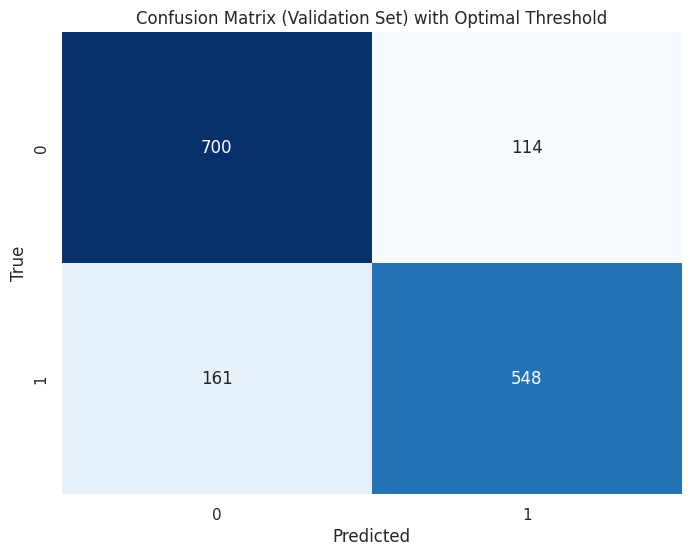


Classification Report (Validation Set) with Optimal Threshold:
              precision    recall  f1-score   support

Non-Disaster       0.81      0.86      0.84       814
    Disaster       0.83      0.77      0.80       709

    accuracy                           0.82      1523
   macro avg       0.82      0.82      0.82      1523
weighted avg       0.82      0.82      0.82      1523



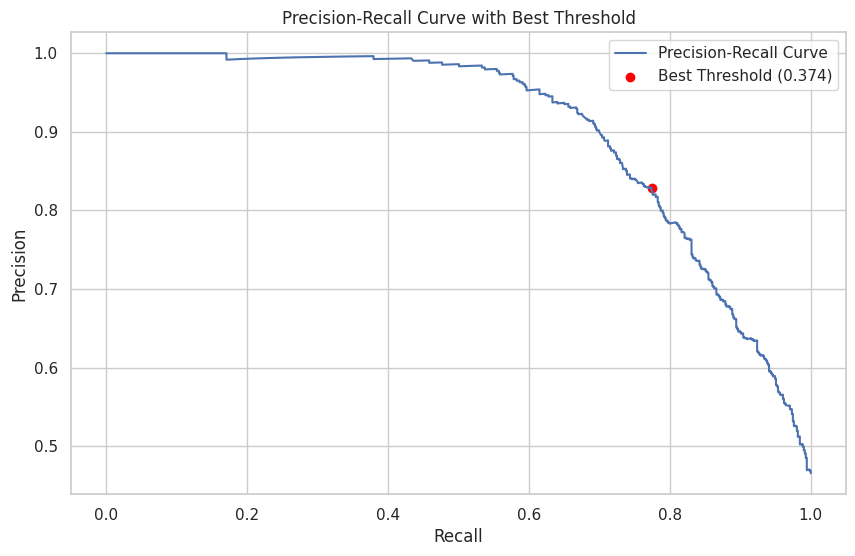


Detailed Analysis at Optimal Threshold:
--------------------------------------
Accuracy: 0.8194
Precision: 0.8278
Recall: 0.7729
F1 Score: 0.7994


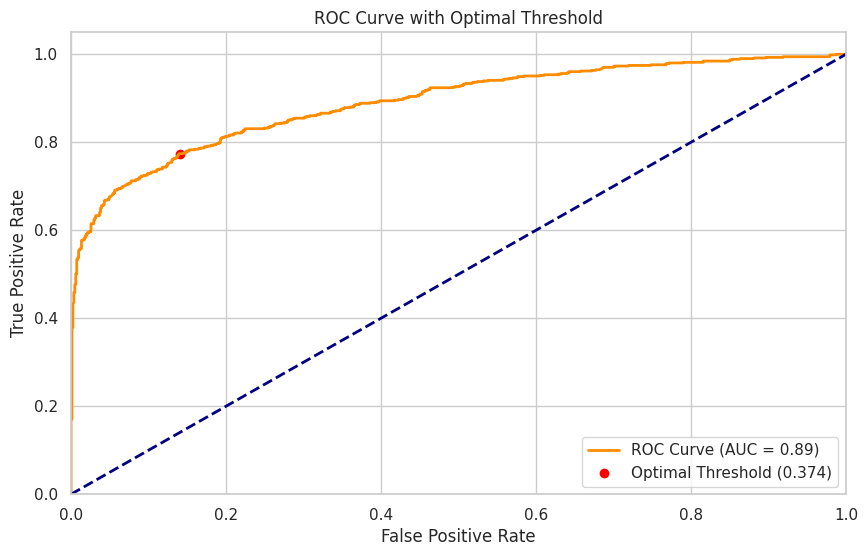


Error Analysis at Optimal Threshold:
-----------------------------------

Sample of Misclassified Examples:

Text: #nowplaying Sinking Fast - Now or Never on North East Unsigned Radio listen at http://t.co/QymAlttvZp
True Label: Non-Disaster
Predicted Label: Disaster
Confidence: 0.4719
Threshold: 0.3741

Text: that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time
True Label: Disaster
Predicted Label: Non-Disaster
Confidence: 0.1331
Threshold: 0.3741

Text: 4 equipment ego break upon dig your family internet hoke excepting versus a sinking term: dfLJEV
True Label: Disaster
Predicted Label: Non-Disaster
Confidence: 0.1190
Threshold: 0.3741

Text: We walk the plank of a sinking ship
True Label: Non-Disaster
Predicted Label: Disaster
Confidence: 0.4190
Threshold: 0.3741

Text: Do you feel like you are sinking in low self-image? Take the quiz: http://t.co/bJoJVM0pjX http://t.co/wHOc7LHb5F
True Label: Disaster
Predi

In [9]:
# CODE BLOCK 10: Threshold Optimization and Detailed Analysis

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve, roc_curve, auc, precision_score,
    recall_score, f1_score, confusion_matrix, classification_report,
    accuracy_score
)
import json

# Generate validation predictions
print("Generating validation predictions...")
val_indices = int(len(X_train_padded) * 0.8)
X_val_padded = X_train_padded[val_indices:]
y_val_true = y_train[val_indices:]

# Predict probabilities on the validation set
val_predictions_proba = best_model.predict(X_val_padded).flatten()

# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_val_true, val_predictions_proba)

# Compute F1 scores for all thresholds
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7)  # Avoid division by zero

# Exclude last threshold to align lengths
thresholds = np.append(thresholds, 1.0)
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]

print(f'\nBest threshold based on F1 score: {best_threshold:.4f}')

# Apply the best threshold
val_predictions_best_threshold = (val_predictions_proba > best_threshold).astype(int)

# Plot confusion matrix with optimal threshold
cm = confusion_matrix(y_val_true, val_predictions_best_threshold)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Validation Set) with Optimal Threshold')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
report = classification_report(y_val_true, val_predictions_best_threshold, target_names=['Non-Disaster', 'Disaster'])
print("\nClassification Report (Validation Set) with Optimal Threshold:")
print(report)

# Plot Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.scatter(
    recall[best_threshold_index], 
    precision[best_threshold_index],
    color='red', 
    marker='o', 
    label=f'Best Threshold ({best_threshold:.3f})'
)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Best Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Additional analysis at optimal threshold
print("\nDetailed Analysis at Optimal Threshold:")
print("--------------------------------------")
print(f"Accuracy: {accuracy_score(y_val_true, val_predictions_best_threshold):.4f}")
print(f"Precision: {precision_score(y_val_true, val_predictions_best_threshold):.4f}")
print(f"Recall: {recall_score(y_val_true, val_predictions_best_threshold):.4f}")
print(f"F1 Score: {f1_score(y_val_true, val_predictions_best_threshold):.4f}")

# Plot ROC curve with optimal threshold
fpr, tpr, roc_thresholds = roc_curve(y_val_true, val_predictions_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Find point on ROC curve closest to optimal threshold
optimal_idx = np.argmin(np.abs(roc_thresholds - best_threshold))
plt.scatter(
    fpr[optimal_idx], 
    tpr[optimal_idx],
    color='red', 
    marker='o', 
    label=f'Optimal Threshold ({best_threshold:.3f})'
)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Optimal Threshold')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Error analysis at optimal threshold
print("\nError Analysis at Optimal Threshold:")
print("-----------------------------------")

# Get misclassified examples
misclassified_indices = np.where(val_predictions_best_threshold != y_val_true)[0]
val_texts = train_data['text'].values[val_indices:]

print("\nSample of Misclassified Examples:")
for idx in misclassified_indices[:5]:  # Show first 5 misclassified examples
    text = val_texts[idx]
    true_label = y_val_true[idx]
    pred_label = val_predictions_best_threshold[idx]
    confidence = val_predictions_proba[idx]
    
    print(f"\nText: {text}")
    print(f"True Label: {'Disaster' if true_label == 1 else 'Non-Disaster'}")
    print(f"Predicted Label: {'Disaster' if pred_label == 1 else 'Non-Disaster'}")
    print(f"Confidence: {confidence:.4f}")
    print(f"Threshold: {best_threshold:.4f}")

# Save threshold optimization results
threshold_results = {
    'best_threshold': float(best_threshold),
    'metrics': {
        'accuracy': float(accuracy_score(y_val_true, val_predictions_best_threshold)),
        'precision': float(precision_score(y_val_true, val_predictions_best_threshold)),
        'recall': float(recall_score(y_val_true, val_predictions_best_threshold)),
        'f1': float(f1_score(y_val_true, val_predictions_best_threshold)),
        'auc': float(roc_auc)
    },
    'confusion_matrix': cm.tolist()
}

# Save results to a JSON file
with open('threshold_optimization_results.json', 'w') as f:
    json.dump(threshold_results, f, indent=4)

print("\nThreshold optimization results saved to 'threshold_optimization_results.json'.")

In [14]:
# CODE BLOCK 11: Generate Predictions on Test Data and Create Submission File

# Proceed directly to tokenization and prediction

# 1. Tokenize and pad the test data using the tokenizer and maxlen from previous code
X_test_seq = tokenizer.texts_to_sequences(test_data['text'])
X_test_padded = pad_sequences(X_test_seq, maxlen=maxlen)

# 2. Predict probabilities on the test data using the trained model
test_predictions_proba = model.predict(X_test_padded).flatten()

# 3. Apply the threshold to get final binary predictions
test_predictions = (test_predictions_proba > 0.5).astype(int)

# 4. Prepare the submission DataFrame
submission = pd.DataFrame({
    'id': test_data['id'],
    'target': test_predictions
})

# 5. Save the submission DataFrame to a CSV file without the index
submission.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' has been created.")

# Display the first few rows of the submission file to verify
print("First few rows of the submission file:")
display(submission.head(10))


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Submission file 'submission.csv' has been created.
First few rows of the submission file:


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,0
6,21,0
7,22,0
8,27,0
9,29,0


## Conclusion

In this project, we aimed to classify disaster-related tweets using an LSTM model with pre-trained GloVe embeddings. By following a comprehensive approach that included data preprocessing, model training, hyperparameter tuning, and threshold optimization, we were able to create a robust tweet classification system.

### Key Accomplishments:

1. **Data Preprocessing:** 
   - We cleaned and preprocessed the dataset using techniques such as tokenization, stopword removal, and lemmatization. Additionally, the `keyword` feature was combined with the tweet text to enhance the input data.

2. **Modeling Approach:**
   - The core of the project was an LSTM network initialized with GloVe embeddings. These pre-trained word vectors allowed us to leverage semantic and syntactic information, significantly improving the model's ability to understand the context of disaster-related tweets.

3. **Hyperparameter Tuning:**
   - To optimize the model's performance, we performed extensive hyperparameter tuning using Keras Tuner. The best model was identified after 90 trials, with the following hyperparameters:
     - **LSTM Units 1:** 64
     - **LSTM Units 2:** 128
     - **Dense Units:** 128
     - **Dropout Rate:** 0.3
     - **Learning Rate:** 0.00123
     - **Trainable Embedding:** True
   - This tuning process improved the model's validation accuracy to 0.8240, ensuring the architecture was tailored to the complexity of the dataset.

4. **Performance Evaluation:**
   - The final tuned LSTM model was evaluated using accuracy, precision, recall, and F1-score metrics. The results on the validation set were as follows:
     - **Accuracy:** 82%
     - **Precision (Disaster):** 0.89
     - **Recall (Disaster):** 0.71
     - **F1-score (Disaster):** 0.79
   - The model demonstrated strong performance, with good precision for disaster tweets and an overall accuracy of 82%.

5. **Threshold Optimization:**
   - We further refined the model by optimizing the prediction threshold. The optimal threshold of 0.374 improved the balance between precision and recall, helping the model better classify disaster-related tweets while minimizing false positives and false negatives.

### Lessons Learned:

- **Hyperparameter tuning** is a critical process for optimizing deep learning models, allowing us to fine-tune aspects like the number of LSTM units, dense layers, and learning rate for better performance.
- **Pre-trained embeddings** such as GloVe provide a strong foundation for NLP tasks, enabling the model to learn from pre-existing word relationships and patterns, which enhances overall accuracy.
- **Threshold tuning** is a valuable step in fine-tuning classification models, especially when dealing with imbalanced data or specific use-case requirements.

### Future Directions:

While the LSTM model performed well, future enhancements could include experimenting with transformer-based models such as BERT or RoBERTa, which are known to achieve superior results on text classification tasks. Additionally, exploring techniques such as ensembling or advanced feature engineering could further improve performance.

Overall, this project showcased the effectiveness of combining classical NLP techniques with deep learning and hyperparameter tuning to classify disaster-related tweets. These techniques provide a strong foundation for further advancements in real-time disaster detection systems.
